# NaiveBayes

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import calendar

def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Capacity a Nominal
    bins = [0,100,200,300, 400]
    labels = [1,2,3,4]
    df['capacidad'] = pd.cut(df["capacity"], bins, labels=labels, right=False)
    df.drop('capacity', axis=1, inplace=True)

    # Transformamos denied_boarding a Nominal
    bins = [0,10,20,30,40,50]
    labels = [1,2,3,4,5]
    df['denied'] = pd.cut(df["denied_boarding"], bins, labels=labels, right=False)
    df.drop('denied_boarding', axis=1, inplace=True)
    
    # Transformamos Capacity a Nominal
    bins = [0,100,200,300,400,500,600,700]
    labels = [1,2,3,4,5,6,7]
    df['booking'] = pd.cut(df["bookings"], bins, labels=labels, right=False)
    df.drop('bookings', axis=1, inplace=True)
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [10]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
# Procesamos los datos con la funcion procesar_csv()
df = procesar_csv(df)
# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)
# Definimos nuestra columna target
target = df['Labels']
# La eliminamos del dataframe
df.drop('noshow', axis=1, inplace=True)

df.drop('fligth_number', axis=1, inplace=True)
df.drop('p2p', axis=1, inplace=True)
df.drop('distance', axis=1, inplace=True)
df.drop('pax_midlow', axis=1, inplace=True)
df.drop('pax_high', axis=1, inplace=True)
df.drop('pax_midhigh', axis=1, inplace=True)
df.drop('pax_low', axis=1, inplace=True)
df.drop('pax_freqflyer', axis=1, inplace=True)
df.drop('group_bookings', axis=1, inplace=True)
df.drop('out_of_stock', axis=1, inplace=True)
df.drop('dom_cnx', axis=1, inplace=True)
df.drop('int_cnx', axis=1, inplace=True)



#Columnas despues de la limpieza
df.columns

Index(['origin_int', 'destination_int', 'capacidad', 'denied', 'booking',
       'revenues_usd_discr', 'mes', 'horario', 'Labels'],
      dtype='object')

In [11]:
#display(df)
#for i in df.columns:
    #print(i)
    #display(df["bookings"].value_counts())
    #display(df.hist(column = i, bins = 5, grid = False))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df["booking"].value_counts().to_frame())

   booking
2   557072
3   218423
1   189181
4    29493
5     3756
6      536
7        1


display(df)
for i in df.columns:
    display(df[i].value_counts())
    display(df[i].isna())

In [12]:
df

,origin_int,destination_int,capacidad,denied,booking,revenues_usd_discr,mes,horario,Labels
0,12,125,2,1,3,6,11,1,1
1,79,143,2,1,3,2,5,3,0
2,122,116,3,1,1,8,5,1,1
3,27,33,2,1,1,6,2,3,1
4,51,55,2,1,3,8,10,2,1
...,...,...,...,...,...,...,...,...,...
999885,143,27,2,1,1,8,10,2,1
999886,79,57,2,1,3,10,5,1,1
999887,62,125,3,1,2,7,4,2,1
999888,53,126,2,1,2,5,4,1,0


In [14]:
#Crear un objeto de KFold cross validation

#for k in range (2,100, 5):
kf = KFold(n_splits = 100, shuffle = True, random_state = 0)

#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(100)
F1Test = np.zeros(100)

#Crear el objeto de Naive Bayes que estime correspondiente, con el alpha deseado
NB = MultinomialNB()
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df):
        #extraer los datos de entrenamiento y test
        trainData = df.iloc[train_index, :]
        testData = df.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        NB = NB.fit(trainData, trainLabel)

        #Predecir los valores de TrainData y calcule su error
        prediccion = NB.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
    
        #Prediga los valores de testData y calcule su error
        prediccion = NB.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

        i+=1

print("Numero iteraciónes: ", i)
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

Numero iteraciónes:  100
F1-score modelo para training:  0.7204285181397028 +- 7.872924327475411e-05
F1-score modelo para test:  0.7204049820661603 +- 0.007193156854304321


In [9]:
#Muestre la media y desviación estandar de cada error 
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())   

F1-score modelo para training:  0.7919559056332888 +- 3.5307737062786766e-05
F1-score modelo para test:  0.7919457801248194 +- 0.0034956845297918256


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

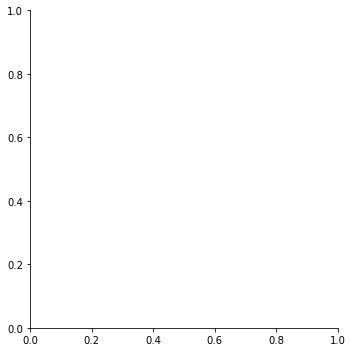

In [16]:
sns.displot(df, x='booking', hue ="Labels", kind = 'kde')

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,target,test_size=0.33, random_state=42)


In [19]:
#Creando un objeto Naive Bayes con las condiciones iniciales
from sklearn.naive_bayes import GaussianNB
NB = MultinomialNB()
NB = NB.fit(X_train,y_train)

#Aplicando el modelo a otros datos
resultado=NB.predict(X_test)
print("Resultado de la predicción:\n",resultado)
print("Resultado original:\n",y_test)

#Aplicando el modelo a otros datos
resultados=NB.predict_proba(X_test)
print("Resultado de la predicción:\n",resultados)

Resultado de la predicción:
 [1 1 0 ... 0 0 0]
Resultado original:
 783891    1
245557    1
586246    0
442245    1
513415    0
         ..
168460    1
418099    0
759751    0
627705    0
306926    0
Name: Labels, Length: 329493, dtype: int64
Resultado de la predicción:
 [[5.53798492e-06 9.99994462e-01]
 [4.09865856e-04 9.99590134e-01]
 [9.89587229e-01 1.04127710e-02]
 ...
 [9.75007672e-01 2.49923282e-02]
 [5.62355114e-01 4.37644886e-01]
 [8.00795804e-01 1.99204196e-01]]


In [20]:
mt.f1_score(y_test, resultado, pos_label = 0)

0.7190449438202247

Límites [2 1 0]


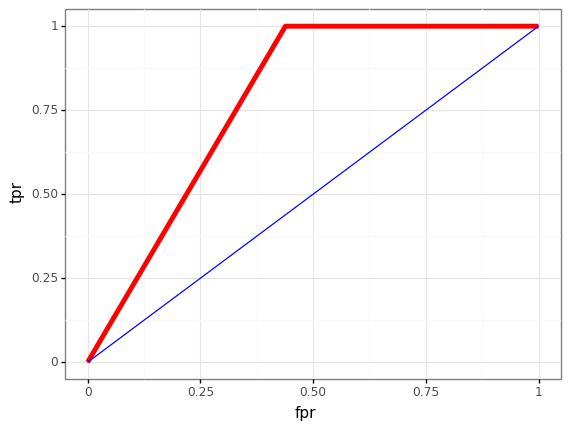


Valor del AUC: 0.7806675145826938


In [23]:
#Calculando los tpr and fpr
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(y_test, resultado, pos_label = 1)
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))